In [1]:
import pandas as pd

In [2]:
pdf = pd.read_csv('../Viavi/viavi20190110_1000event_chains_0o005sample_minimal_cutdown.csv')

In [3]:
pdf.head()

,Imsi_id,SegmentStartTime,Cell_ci,Latitude,Longitude,Uncertainty,MobClass
0,1806,1547106710361,25756418,50.806411,7.314754,1220,1
1,1806,1547106744307,25756418,50.795022,7.300875,813,1
2,1806,1547106774790,25756418,50.784885,7.295851,813,1
3,1806,1547106793016,34686720,50.795313,7.319098,352,1
4,1806,1547106759305,25756418,50.762980,7.290606,542,1


In [5]:
import pyproj
import json
from shapely.geometry import Point, Polygon, mapping
from functools import partial
from shapely.ops import transform

In [8]:
def projected_coords(df,project_it=False):
    import pyproj as proj

    # setup your projections
    crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
    crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

    xvals = df.Longitude.values
    yvals = df.Latitude.values
    
    if not project_it:
        return xvals, yvals
    else:
        # then cast your geographic coordinate pair to the projected system
        return proj.transform(crs_wgs, crs_bng, xvals, yvals)

In [9]:
x,y = projected_coords(pdf,True)

In [14]:
pdf['x'] = pd.Series(x)
pdf['y'] = pd.Series(y)

In [15]:
pdf.head()

,Imsi_id,SegmentStartTime,Cell_ci,Latitude,Longitude,Uncertainty,MobClass,x,y
0,1806,1547106710361,25756418,50.806411,7.314754,1220,1,1.055853e+06,142235.586248
1,1806,1547106744307,25756418,50.795022,7.300875,813,1,1.055038e+06,140848.665034
2,1806,1547106774790,25756418,50.784885,7.295851,813,1,1.054828e+06,139679.664303
3,1806,1547106793016,34686720,50.795313,7.319098,352,1,1.056315e+06,141043.644674
4,1806,1547106759305,25756418,50.762980,7.290606,542,1,1.054767e+06,137203.618366


In [40]:
%matplotlib inline

In [41]:
import matplotlib.pyplot

In [42]:
from matplotlib import rcParams
rcParams['figure.figsize']=[25,15]

rcParams['font.size'] = 24.0


# Markers
rcParams['lines.markeredgewidth'] = 2.0
rcParams['lines.markersize'] = 10

rcParams['lines.linewidth'] = 3.0

# Borders and grid
axes_thickness = 1.0
rcParams['axes.linewidth'] = 2*axes_thickness
rcParams['grid.linewidth'] = axes_thickness
rcParams['xtick.major.width'] = axes_thickness
rcParams['xtick.minor.width'] = axes_thickness
rcParams['ytick.major.width'] = axes_thickness
rcParams['ytick.minor.width'] = axes_thickness

In [153]:
pdf_counts = pdf.groupby('Imsi_id')['SegmentStartTime'].nunique()

In [154]:
pdf_counts.head()

Imsi_id
76      909
150      70
214    2697
280     616
461     969
Name: SegmentStartTime, dtype: int64

In [155]:
pdf_one = pdf[pdf['Imsi_id'] == 214].copy()

In [156]:
pdf_one.sort_values('SegmentStartTime', ascending=True, inplace=True)

In [157]:
time_zero = pdf_one.SegmentStartTime.min()

In [158]:
pdf_one['time_diff'] = pdf_one.SegmentStartTime.apply(lambda x: (x-time_zero)/1000.0)

In [159]:
pdf_one.head()

,Imsi_id,SegmentStartTime,Cell_ci,Latitude,Longitude,Uncertainty,MobClass,x,y,time_diff
141980,214,1547078690514,27313922,50.814909,7.141795,514,3,1.043581e+06,141647.648028,0.000
141773,214,1547078690514,27313922,50.814909,7.141795,514,3,1.043581e+06,141647.648028,0.000
142057,214,1547078690556,27313922,50.814909,7.141795,514,3,1.043581e+06,141647.648028,0.042
142063,214,1547078690556,27313922,50.814909,7.141795,514,3,1.043581e+06,141647.648028,0.042
142030,214,1547078691313,27313922,50.814909,7.141795,514,3,1.043581e+06,141647.648028,0.799


Text(0.5, 0, 'time')

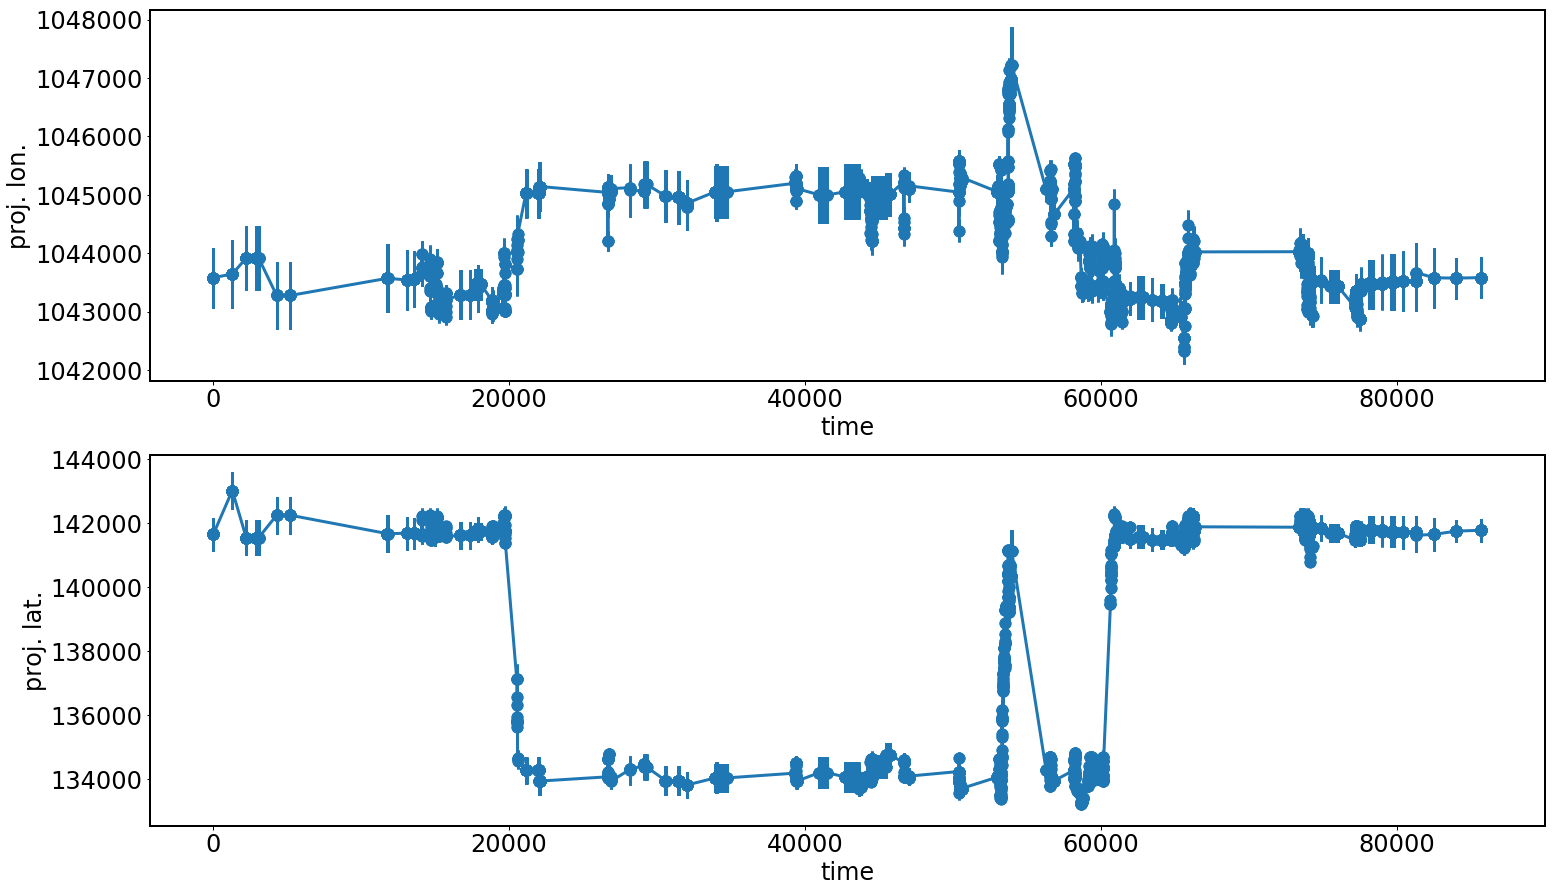

In [160]:
ax = plt.subplot(211)
ax.errorbar(pdf_one.time_diff.values, pdf_one.x.values, yerr=pdf_one.Uncertainty.values, fmt='o-')
ax.set_ylabel('proj. lon.')
ax.set_xlabel('time')
ax = plt.subplot(212)
ax.errorbar(pdf_one.time_diff.values, pdf_one.y.values, yerr=pdf_one.Uncertainty.values, fmt='o-')
ax.set_ylabel('proj. lat.')
ax.set_xlabel('time')

In [161]:
uncert_max = pdf_one.Uncertainty.max()

In [172]:
from shapely.geometry import box #shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
from shapely.geometry.polygon import LinearRing, Polygon

In [108]:
import numpy as np

# Activity cutting

In [204]:
uncert_max = pdf_one.Uncertainty.max()
x_max = pdf_one.x.max()
x_min = pdf_one.x.min()
x_loc0 = pdf_one.x.iloc[0]

dt_max = pdf_one.time_diff.max()
dt_min = pdf_one.time_diff.min()

tvals = pdf_one.time_diff.values
xvals = pdf_one.x.values
uvals = pdf_one.Uncertainty.values

find_activity = []
counted=0
last_counted=0
activity_indices=[]
new_window = error_window
for n in range(number_rows):

    xval = xvals[n]
 
    tval = tvals[n]    

    uval = uvals[n]
    
    path = LineString([(tval,xval-uval), (tval,xval+uval)])
    
    counted+=1
    if not path.intersects(new_window):
        activity_indices.append((last_counted, counted-1))
        last_counted=counted
        new_window = box(tval, xval-uncert_max, dt_max, xval+uncert_max)
        
activity_indices.append((last_counted, counted))        

# Plot the results

Text(0.5, 0, 'time')

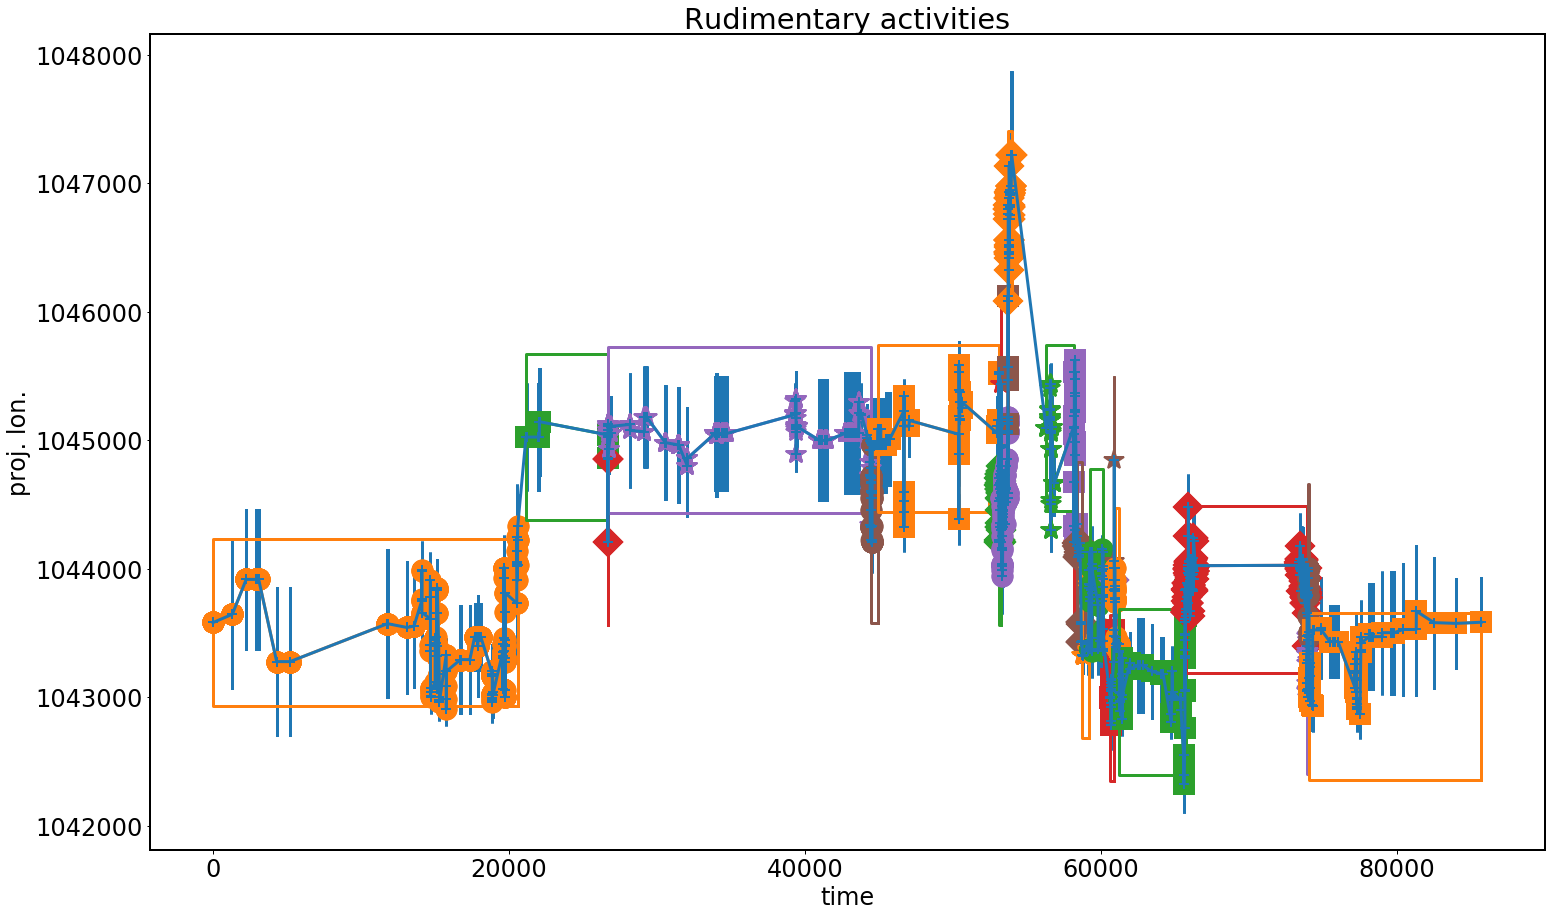

In [205]:

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = plt.subplot(111)

ax.set_title('Rudimentary activities')
ax.errorbar(pdf_one.time_diff.values, pdf_one.x.values, yerr=pdf_one.Uncertainty.values, fmt='+-')

markerings = ['o', 's', 'D', '*']
colorings = ['C1','C2','C3','C4','C5']
for n, pair in enumerate(activity_indices):
    
    # Get the x,t-pairs
    tvals = pdf_one.time_diff.values[np.array(range(pair[0],pair[1]))]    
    xvals = pdf_one.x.values[np.array(range(pair[0],pair[1]))]
    
    # Define the box coords
    xval = xvals[0]
    tval = tvals[0] 
    tmax = tvals[-1] 
    new_window = box(tval, xval-uncert_max, tmax, xval+uncert_max)
    
    # Get the window coords
    x, y = new_window.exterior.xy
    ax.plot(x, y, color=colorings[n%5])
    
    # Plot the Activity events
    ax.plot(tvals, xvals, marker=markerings[n%4], markersize=20.0, color=colorings[n%5])

    
ax.set_ylabel('proj. lon.')
ax.set_xlabel('time')

## Some notes

* the Activities are biased from their initial points; shifting them 'up'/'down' would alter the Activities

new_activity_indices = []
for pair in activity_indices:
    
    # Get the x,t-pairs
    tvals = pdf_one.time_diff.values[np.array(range(pair[0],pair[1]))]    
    xvals = pdf_one.x.values[np.array(range(pair[0],pair[1]))]
    
    # Define the box coords
    xval = xvals[0]
    tval = tvals[0] 
    tmin = tvals[0]
    tmax = tvals[-1] 

    if tmax-tmin >= 300:
        new_activity_indices.append(pair)
    

In [210]:
len(activity_indices)

26

In [211]:
len(list(zip(activity_indices[0:-2],activity_indices[1:-1],activity_indices[2:])))

24

In [271]:
merged_activity_indices = []

pair0 = activity_indices[0]

tvals1 = pdf_one.time_diff.values[np.array(range(pair0[0],pair0[1]))]    
xvals1 = pdf_one.x.values[np.array(range(pair0[0],pair0[1]))]

# Define the box coords
tmin1 = tvals1[0]
tmax1 = tvals1[-1]

if (tmax1-tmin1 > 600):
    merged_activity_indices.append(pair0)
    
tupled = list(zip(activity_indices[0:-2],activity_indices[1:-1],activity_indices[2:]))    
    
    
#pairs0 = activity_indices[0:-2]
pairs1 = activity_indices[1:-1]
pairs2 = activity_indices[2:]    
n=0
pair0, pair1, pair2 = tupled[n]
while n<len(tupled):
    
    # Get the x,t-pairs
    tvals0 = pdf_one.time_diff.values[np.array(range(pair0[0],pair0[1]))]    
    xvals0 = pdf_one.x.values[np.array(range(pair0[0],pair0[1]))]
    
    tvals1 = pdf_one.time_diff.values[np.array(range(pair1[0],pair1[1]))]    
    xvals1 = pdf_one.x.values[np.array(range(pair1[0],pair1[1]))]
    
    tvals2 = pdf_one.time_diff.values[np.array(range(pair2[0],pair2[1]))]    
    xvals2 = pdf_one.x.values[np.array(range(pair2[0],pair2[1]))]
        
    # Define the box coords
    xval0 = xvals0[0]
    tval0 = tvals0[0] 
    tmin0 = tvals0[0]
    tmax0 = tvals0[-1] 
    
    xval1 = xvals1[0]
    tval1 = tvals1[0] 
    tmin1 = tvals1[0]
    tmax1 = tvals1[-1] 
    
    xval2 = xvals2[0]
    tval2 = tvals2[0] 
    tmin2 = tvals2[0]
    tmax2 = tvals2[-1] 

    xvals0_mean = np.mean(xvals0)
    xvals2_mean = np.mean(xvals2)    

    xvals0_med = np.median(xvals0)
    xvals2_med = np.median(xvals2)    
    
    # If the time is too short and the median (and mean) of neighboring activities are within uncert, merge
    
    # Check that the xmin,xmax for each activity are within uncert; problem is when this is violated for the merged activities
    
    
    n+=1
    if (tmax1-tmin1<= 600) \
        & (abs(xvals2_mean-xvals0_mean)<uncert_max) \
        & (abs(xvals2_med-xvals0_med)<uncert_max):
        & (abs(xvals2_mean-xvals0_mean)<uncert_max) \
        & (abs(xvals2_med-xvals0_med)<uncert_max):
        

        new_pair = (pair0[0],pair2[-1])
        
        if merged_activity_indices[-1][0]==new_pair[0]:
            merged_activity_indices.pop()
                
        merged_activity_indices.append(new_pair)
        pair0 = new_pair
        print(n,"merged\t",pair0, pair1, pair2)
        n+=1
        if n>=len(tupled): break
        _, pair1, pair2 = tupled[n]
    else:
        print(n,"unmerged\t",pair0, pair1, pair2)
        pair0, pair1, pair2 = tupled[n]
        print("\t\t",pair0, pair1, pair2,)


pair1 = activity_indices[-1]

tvals1 = pdf_one.time_diff.values[np.array(range(pair1[0],pair1[1]))]    
xvals1 = pdf_one.x.values[np.array(range(pair1[0],pair1[1]))]

# Define the box coords
tmin1 = tvals1[0]
tmax1 = tvals1[-1]

if (tmax1-tmin1 > 600):
    merged_activity_indices.append(pair1)
    

1 unmerged	 (0, 838) (839, 944) (945, 954)
		 (839, 944) (945, 954) (955, 1732)
2 merged	 (839, 1732) (945, 954) (955, 1732)
4 merged	 (839, 2500) (1733, 1976) (1977, 2500)
6 merged	 (839, 2584) (2501, 2580) (2581, 2584)
8 merged	 (839, 2776) (2585, 2760) (2761, 2776)
10 merged	 (839, 2996) (2777, 2898) (2899, 2996)
12 merged	 (839, 3074) (2997, 3000) (3001, 3074)
14 unmerged	 (839, 3074) (3075, 3142) (3143, 3182)
		 (3075, 3142) (3143, 3182) (3183, 3348)
15 merged	 (3075, 3348) (3143, 3182) (3183, 3348)
17 merged	 (3075, 3426) (3349, 3422) (3423, 3426)
19 merged	 (3075, 3510) (3427, 3434) (3435, 3510)
21 unmerged	 (3075, 3510) (3511, 3878) (3879, 4524)
		 (3511, 3878) (3879, 4524) (4525, 4562)
22 unmerged	 (3511, 3878) (3879, 4524) (4525, 4562)
		 (3879, 4524) (4525, 4562) (4563, 4614)
23 merged	 (3879, 4614) (4525, 4562) (4563, 4614)


In [272]:
merged_activity_indices

[(0, 838), (839, 3074), (3075, 3510), (3879, 4614), (4615, 5400)]

Text(0.5, 0, 'time')

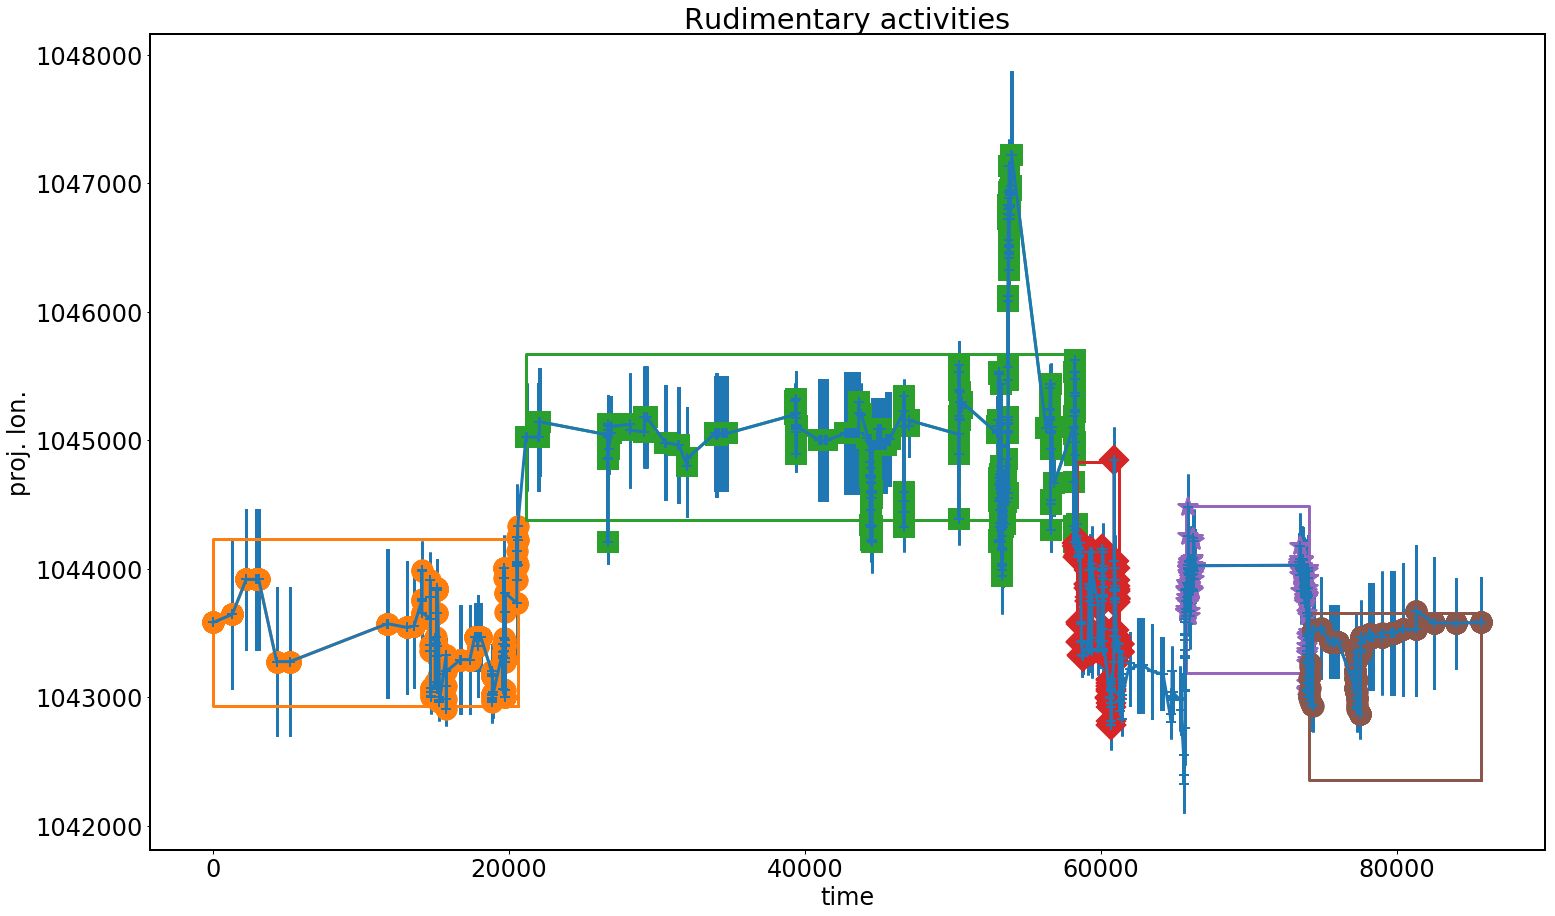

In [273]:
#fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = plt.subplot(111)

ax.set_title('Rudimentary activities')
ax.errorbar(pdf_one.time_diff.values, pdf_one.x.values, yerr=pdf_one.Uncertainty.values, fmt='+-')

markerings = ['o', 's', 'D', '*']
colorings = ['C1','C2','C3','C4','C5']
for n, pair in enumerate(merged_activity_indices):
    
    # Get the x,t-pairs
    tvals = pdf_one.time_diff.values[np.array(range(pair[0],pair[1]))]    
    xvals = pdf_one.x.values[np.array(range(pair[0],pair[1]))]
    
    # Define the box coords
    xval = xvals[0]
    tval = tvals[0] 
    tmax = tvals[-1] 
    new_window = box(tval, xval-uncert_max, tmax, xval+uncert_max)
    
    # Get the window coords
    x, y = new_window.exterior.xy
    ax.plot(x, y, color=colorings[n%5])
    
    # Plot the Activity events
    ax.plot(tvals, xvals, marker=markerings[n%4], markersize=20.0, color=colorings[n%5])

    
ax.set_ylabel('proj. lon.')
ax.set_xlabel('time')
#ax.set_xlim(20000,30000)